In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import math

In [2]:
path = 'Data Segmentation'
file_names = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']
time = ['Evening', 'Morning', 'Night']

class_file_label = {j:i for i ,j in enumerate(file_names)}
nb_classes=len(file_names)

# Specify the file path to store the h5py
file_path = 'data.h5'

IMAGE_SIZE = (100, 100)

In [3]:
def load_data():
    dataset = [path]
    
    # Read data
    for data in dataset:

        images = []
        labels = []

        print("loading {}".format(data))

        for folder in os.listdir(data):
            label = class_file_label[folder]

            for timeslot in os.listdir(os.path.join(data,folder)):
                for file in os.listdir(os.path.join(data,folder,timeslot)):
                    if file[-3:] in {'png','jpg','jpeg'}:
                        # Set the file path(eg.path/7-11/evening/image_name)
                        img_path = os.path.join(os.path.join(data, folder, timeslot, file))

                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(IMAGE_SIZE)

                        images.append(img)
                        labels.append(label)
        images = np.array([np.array(i) for i in images])
        labels = np.array([np.array(i) for i in labels])
        
        print(type(images))
    return images,labels

In [4]:
(X, y) = load_data()

loading Data Segmentation
<class 'numpy.ndarray'>


In [5]:
print(X.shape)
print(y.shape)

(322, 100, 100, 3)
(322,)


In [6]:
root_folder = 'Data Segmentation'
stores = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']
times = ['Evening', 'Morning', 'Night']

# Load and preprocess the images
images = []
labels = []

for store in stores:
    store_path = os.path.join(root_folder, store)
    if os.path.exists(store_path):
        for time in times:
            time_path = os.path.join(store_path, time)
            
            if os.path.exists(time_path):
                image_files = [f for f in os.listdir(time_path) if f.endswith('png') or f.endswith('jpg') or f.endswith('jpeg')]
                
                for image_file in image_files:
                    image_path = os.path.join(time_path, image_file)
                    image = Image.open(image_path).convert('RGB')
                    image_resized = image.resize(IMAGE_SIZE)
                    images.append(np.array(image_resized))
                    labels.append(store)
            else:
                print(f"Time folder not found: {time_path}")
    else:
        print(f"Store folder not found: {store_path}")

# Convert the lists to numpy arrays
mapping = {'7-11': 0, '99 Speedmart': 1, 'DM Mart':2, 'Family Mart': 3,'Oppa Mart': 4,'myNews': 5}

# Replace values in the list using the mapping dictionary
labels = [mapping.get(item, item) for item in labels]

labels = np.array(labels)

In [7]:
# Create a new HDF5 file
with h5py.File("data.h5", "w") as f:
  f.create_dataset("dataset1", data=images)  
  f.create_dataset("dataset2", data=labels)

In [8]:
from sklearn.decomposition import PCA

# Open the HDF5 file in read mode
file = h5py.File(file_path, 'r')
images = file['dataset1'][:]
# Read dataset2 and assign it to labels
labels = file['dataset2'][:]
# Flatten the images into a 1D array
flattened_images = images.reshape(images.shape[0], -1)

from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, x_test, y_train, y_test = train_test_split(flattened_images, labels, test_size=0.4, random_state=101)

# Feature scaling
X_train = X_train/255
x_test = x_test/255

# Apply PCA for dimensionality reduction
n_components = 101  # Choose the number of components as needed
pca = PCA(n_components=n_components, random_state = 83)
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(x_test)
    
file.close()

In [24]:
print(X_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(193, 30000)
(193,)
(130, 30000)
(130,)


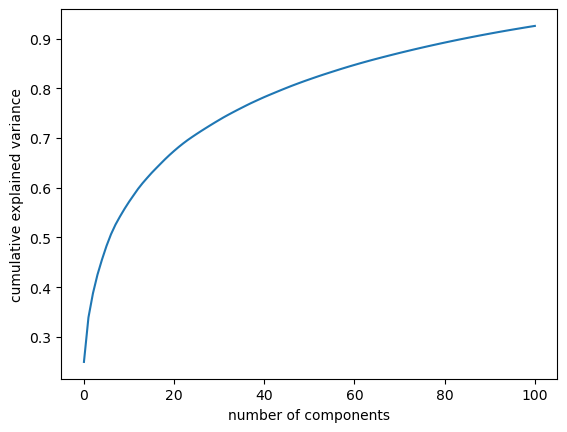

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [10]:
# def image_grid(D,T,H,W,cols=10,scale=1):
#     """ display a grid of images
#         H,W: Height and width of the images
#         cols: number of columns = number of images in each row
#         scale: 1 to fill screen
#     """
#     n = np.shape(D)[0]
#     rows = int(math.ceil((n+0.0)/cols))
#     fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
#     for i in range(n):
#         plt.subplot(rows,cols,i+1)
#         fig=plt.imshow(np.reshape(D[i,:],[H,W]))
#         plt.axis('off')
#         plt.title(T[i])

# #show training images
# image_grid(flattened_images,labels,100,100)
# plt.show()

In [11]:
# Write the dataset into the h5 file
# Create a new HDF5 file at the specified path
file.close()
size_limit = 10 * 1024  # Size limit in kilobytes (e.g., 10 MB)

if os.path.exists(file_path) and os.path.getsize(file_path) > size_limit:
    # if File exists and exceeds the size limit
    file = h5py.File(file_path, 'r+')
    dataset1 = file['dataset1']
    dataset2 = file['dataset2']

    if 'dataset1' in dataset1 and 'dataset2' in dataset2:
        # Update existing datasets
        dataset1['dataset1'][:] = images
        dataset2['dataset2'][:] = labels
    file.close()
    
else:
    # File does not exist ,then create the hdf5 file
    
    # Create a new HDF5 file
    with h5py.File("data.h5", "w") as f:
        f.create_dataset("dataset1", data=images)  
        f.create_dataset("dataset2", data=labels)
    
    # Close the HDF5 file
    file.close()

# Ways to check the data in h5 file
# file = h5py.File(file_path, 'r')
# for images in file['dataset1']:
#    print(images)

# checkStore = 0
# for labels in file['dataset2']:
#     if (labels == 0):
#         checkStore += 1

# print(checkStore)
# file.close()

C:\Users\tzhen\AppData\Local\Temp\ipykernel_1160\2249499401.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'dataset1' in dataset1 and 'dataset2' in dataset2:


In [12]:
# Euclidean Distance
from scipy.spatial.distance import cdist

# Calculate the Euclidean distance between test samples and training samples
distances = cdist(x_test_pca, x_train_pca, metric='euclidean')

# Find the nearest neighbor for each test sample
nearest_indices = np.argmin(distances, axis=1)
y_pred_ed = y_train[nearest_indices]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_ed)
precision = precision_score(y_test, y_pred_ed, average='macro')
recall = recall_score(y_test, y_pred_ed, average='macro')
f1 = f1_score(y_test, y_pred_ed, average='macro')

print("Euclidean distance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report

# Calculate evaluation metrics
classification_report = classification_report(y_test, y_pred_ed)
print()
print("Euclidean distance Classification Report:")
print(classification_report)

Euclidean distance:
Accuracy: 0.7769230769230769
Precision: 0.8571428571428571
Recall: 0.787259483811208
F1-score: 0.7931325596239257

Euclidean distance Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.78      0.70      0.74        20
           2       0.48      1.00      0.65        20
           3       1.00      0.58      0.73        26
           4       1.00      0.86      0.92        14
           5       0.89      0.83      0.86        29

    accuracy                           0.78       130
   macro avg       0.86      0.79      0.79       130
weighted avg       0.86      0.78      0.79       130



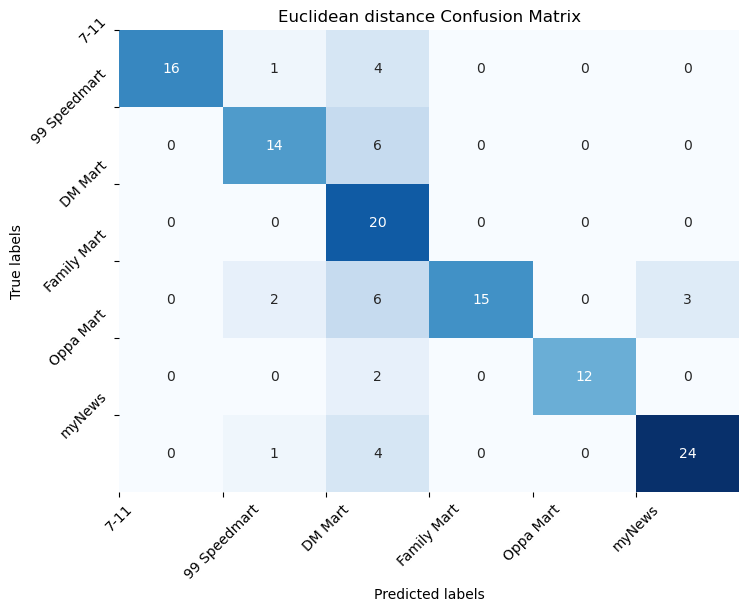

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_ed)

# Define the store names
store_names = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Euclidean distance Confusion Matrix")

# Set the x-axis tick labels to store names
plt.xticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
plt.yticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
# Show the plot
plt.show()

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model and determine optimal hyperparameters
best_accuracy = 0
best_k = 0

# Hyperparameter tuning loop
for k in range(1, min(400, len(x_train_pca) + 1)):
    # Train the KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)

    # Validate the model on the validation set
    y_val_pred = knn.predict(x_train_pca)
    accuracy = accuracy_score(y_train, y_val_pred)
    
    # Check if the current model is the best based on validation accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        
# Initialize and train the K-NN classifier
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train_pca, y_train)
        
# Predict the classes for the test set
y_pred_knn = knn.predict(x_test_pca)
# Calculate evaluation metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='macro')
recall = recall_score(y_test, y_pred_knn, average='macro')
f1 = f1_score(y_test, y_pred_knn, average='macro')

print("K-NN:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report

# Calculate evaluation metrics
classification_report = classification_report(y_test, y_pred_knn)
print()
print("K-NN Classification Report:")
print(classification_report)

c:\Users\tzhen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\tzhen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

K-NN:
Accuracy: 0.7769230769230769
Precision: 0.8571428571428571
Recall: 0.787259483811208
F1-score: 0.7931325596239257

K-NN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.78      0.70      0.74        20
           2       0.48      1.00      0.65        20
           3       1.00      0.58      0.73        26
           4       1.00      0.86      0.92        14
           5       0.89      0.83      0.86        29

    accuracy                           0.78       130
   macro avg       0.86      0.79      0.79       130
weighted avg       0.86      0.78      0.79       130



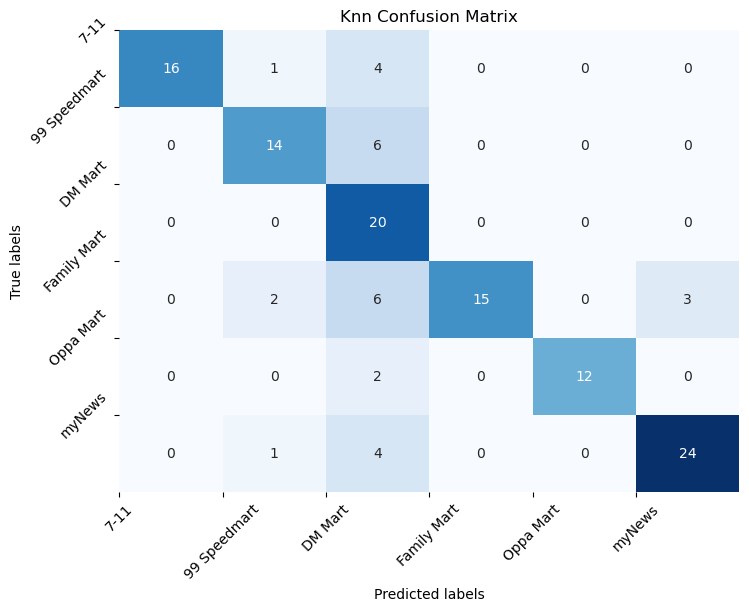

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Define the store names
store_names = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Knn Confusion Matrix")

# Set the x-axis tick labels to store names
plt.xticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
plt.yticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
# Show the plot
plt.show()

In [16]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(1500, 500), max_iter=5000, random_state=42)
mlp.fit(x_train_pca, y_train)

# Predict the classes for the test set
y_pred_nn = mlp.predict(x_test_pca)
# Calculate evaluation metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_nn)
precision = precision_score(y_test, y_pred_nn, average='macro')
recall = recall_score(y_test, y_pred_nn, average='macro')
f1 = f1_score(y_test, y_pred_nn, average='macro')

# Calculate evaluation metrics
print("Neural network:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report

classification_report = classification_report(y_test, y_pred_nn)
print()
print("Neural network Classification Report:")
print(classification_report)

Neural network:
Accuracy: 0.8846153846153846
Precision: 0.892943409247757
Recall: 0.9008599637909981
F1-score: 0.8800093585947543

Neural network Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.87      1.00      0.93        20
           2       0.90      0.95      0.93        20
           3       1.00      0.65      0.79        26
           4       0.58      1.00      0.74        14
           5       1.00      0.90      0.95        29

    accuracy                           0.88       130
   macro avg       0.89      0.90      0.88       130
weighted avg       0.92      0.88      0.89       130



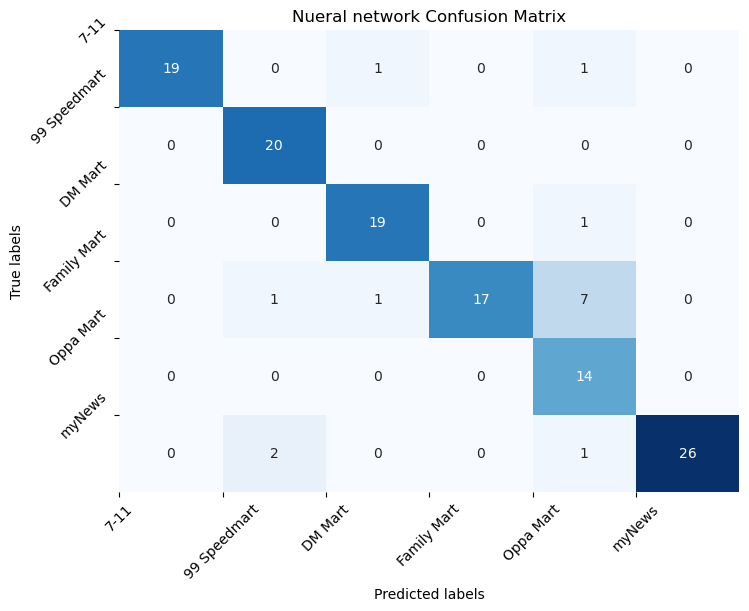

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# Define the store names
store_names = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Nueral network Confusion Matrix")

# Set the x-axis tick labels to store names
plt.xticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
plt.yticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
# Show the plot
plt.show()

In [18]:
from sklearn.svm import SVC

# Initialize and train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(x_train_pca, y_train)

# Predict the classes for the test set
y_pred_svc = svm.predict(x_test_pca)
# Calculate evaluation metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc, average='macro')
recall = recall_score(y_test, y_pred_svc, average='macro')
f1 = f1_score(y_test, y_pred_svc, average='macro')

# Calculate evaluation metrics
print("SVM:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report

classification_report = classification_report(y_test, y_pred_svc)
print()
print("SVM Classification Report:")
print(classification_report)

SVM:
Accuracy: 0.8846153846153846
Precision: 0.9083942877046325
Recall: 0.8945581238684688
F1-score: 0.8892631264682082

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.82      0.90      0.86        20
           2       0.67      1.00      0.80        20
           3       1.00      0.69      0.82        26
           4       1.00      1.00      1.00        14
           5       0.97      0.97      0.97        29

    accuracy                           0.88       130
   macro avg       0.91      0.89      0.89       130
weighted avg       0.91      0.88      0.89       130



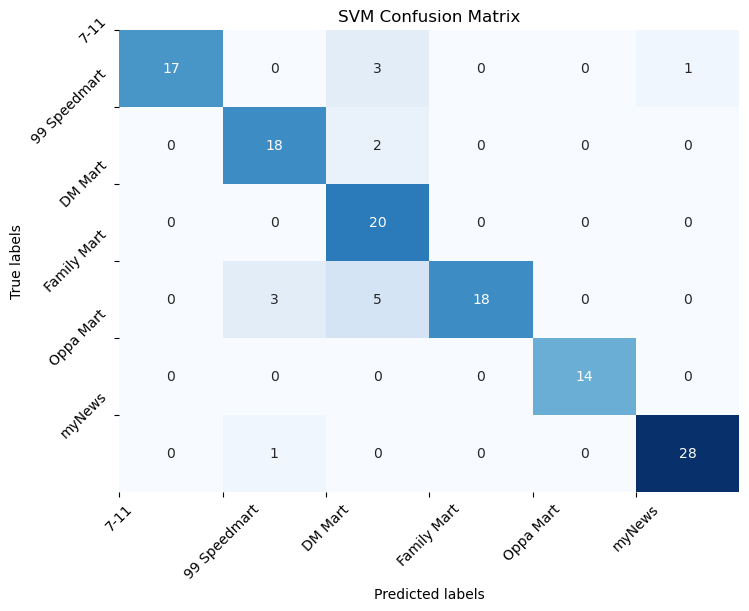

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)

# Define the store names
store_names = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("SVM Confusion Matrix")

# Set the x-axis tick labels to store names
plt.xticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
plt.yticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
# Show the plot
plt.show()

In [20]:
from sklearn.linear_model import Perceptron

# Initialize and train the Perceptron
p = Perceptron(max_iter = 100, random_state = 76)
p.fit(x_train_pca ,y_train)

# Predict the classes for the test set
y_pred_perceptron = p.predict(x_test_pca)
# Calculate evaluation metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_perceptron)
precision = precision_score(y_test, y_pred_perceptron, average='macro')
recall = recall_score(y_test, y_pred_perceptron, average='macro')
f1 = f1_score(y_test, y_pred_perceptron, average='macro')

# Calculate evaluation metrics
print("Perceptron:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report

classification_report = classification_report(y_test, y_pred_perceptron)
print()
print("Perceptron Classification Report:")
print(classification_report)

Perceptron:
Accuracy: 0.9538461538461539
Precision: 0.9490151515151516
Recall: 0.9594153930360827
F1-score: 0.9527977044476327

Perceptron Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.91      1.00      0.95        20
           2       0.95      0.95      0.95        20
           3       0.96      0.92      0.94        26
           4       0.88      1.00      0.93        14
           5       1.00      0.93      0.96        29

    accuracy                           0.95       130
   macro avg       0.95      0.96      0.95       130
weighted avg       0.96      0.95      0.95       130



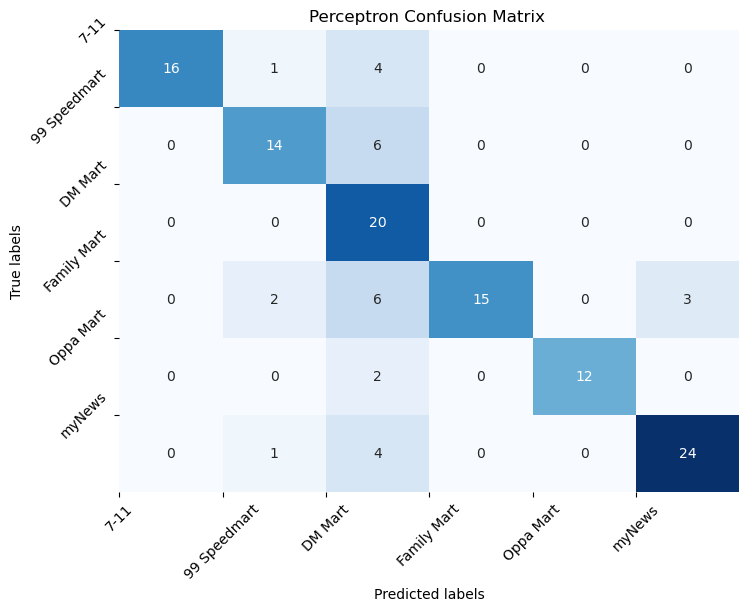

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_ed)

# Define the store names
store_names = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Perceptron Confusion Matrix ")

# Set the x-axis tick labels to store names
plt.xticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
plt.yticks(ticks=range(len(store_names)), labels=store_names, rotation=45)
# Show the plot
plt.show()

In [22]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
from PIL import Image, ImageTk

# Global variables to store the loaded images and canvas objects
loaded_images = []
canvas_list = []

store_label = ['7-11', '99 Speedmart', 'DM Mart', 'Family Mart', 'Oppa Mart', 'myNews']

# Define the classifiers
classifiers = ['KNeighborsClassifier','MLPClassifier','Perceptron','SupportVectorClassifier','EuclideanDistance']  # Add your classifier options here
selected_classifier = classifiers[0] # Set the default selected classifier


def perform_pattern_recognition():
    # Get the diagram input value

    # Get the file paths of the uploaded images
    file_paths = [image["file_path"] for image in loaded_images]

    # Perform pattern recognition and generate the output using diagram_input and file_paths
    output = algorithm(file_paths)
    
    # Selection box for algorithm
    selected_classifier = classifier_combo.get()
    
    # Display the output
    output_text.delete("1.0", tk.END)
    output_text.insert(tk.END, output)

def algorithm(file_paths):
    # Implement the algorithm here for the training
    # Load image
    img = Image.open(file_paths[0]).convert('RGB')

    # Resize image
    img = img.resize((100, 100))
    
    # Convert image to NumPy array
    img_array = np.array(img)
    
    validate_img = img_array.reshape(-1, (100*100*3))
    
    validate_img = validate_img / 255
    
    reduce_validate_img = pca.transform(validate_img)
    
    if selected_classifier == 'KNeighborsClassifier':
        pred = knn.predict(reduce_validate_img)
    elif selected_classifier == 'MLPClassifier':
        pred = mlp.predict(reduce_validate_img)
    elif selected_classifier == 'Perceptron':
        pred = p.predict(reduce_validate_img)
    elif selected_classifier == 'SupportVectorClassifier':
        pred = svm.predict(reduce_validate_img)
    elif selected_classifier == 'EuclideanDistance':
        pred = nearest_indices.predict(reduce_validate_img)
        
    return store_label[pred[0]]

def browse_image():
    # Open the file dialog to select multiple images
    file_paths = filedialog.askopenfilenames(filetypes = [("Image files", "*.png *.jpg *.jpeg")])

    # Clear previously loaded images and canvas objects
    loaded_images.clear()
    for canvas in canvas_list:
        canvas.destroy()
    canvas_list.clear()

    # Iterate over the selected file paths
    for file_path in file_paths:
        # Load the image
        image = Image.open(file_path)
        image.thumbnail((200, 200))  # Resize the image for display

        # Store the loaded image and its file path
        loaded_images.append({"image": image, "file_path": file_path})

        # Create a new canvas for the image
        canvas = tk.Canvas(window, width=200, height=200)
        canvas.grid(row=0, column=len(canvas_list))  # Arrange canvas in a row
        canvas_list.append(canvas)

        # Display the image on the canvas
        image_tk = ImageTk.PhotoImage(image)
        canvas.create_image(0, 0, anchor=tk.NW, image=image_tk)
        canvas.image = image_tk

# Create the main window
window = tk.Tk()
window.title("Cincai Lah")

# Create the diagram input section
diagram_input_label = tk.Label(window, text="Diagram Input:")
diagram_input_label.grid(row=1, column=0, sticky="w")

# diagram_input_text = tk.Text(window, height=4, width=50)
# diagram_input_text.grid(row=2, column=0)

# Create an "Upload Image" button
upload_button = tk.Button(window, text="Upload Image", command=browse_image)
upload_button.grid(row=2, column=0, pady=10)

classifier_label = tk.Label(window, text="Select Classifier:")
classifier_label.grid(row=3, column=0, sticky="w")

classifier_combo = ttk.Combobox(window, values=classifiers, state="readonly")
classifier_combo.current(0)  # Set the default selected classifier
classifier_combo.grid(row=4, column=0)

# Create a horizontal line separator
separator = ttk.Separator(window, orient="horizontal")
separator.grid(row=5, column=0, sticky="we", pady=10)

# Create the start button
start_button = tk.Button(window, text="Start Predict", command=perform_pattern_recognition)
start_button.grid(row=6, column=0)

# Create the output section
output_label = tk.Label(window, text="Predicted Convenience Store:")
output_label.grid(row=7, column=0, sticky="w")

output_text = tk.Text(window, height=4, width=50)
output_text.grid(row=8, column=0)

# Run the main event loop
window.mainloop()